In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np

import pandas as pd 

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime

# scipy for statistics and optimization
from scipy import stats
from scipy import optimize
from scipy.optimize import minimize

# cvxpy
import cvxpy as cp

# typehints
from typing import Union, List, Tuple

"""
Own packages
"""

from codelib.statistics.moments import corr_to_cov_matrix
from codelib.statistics import moments

from codelib.portfolio_optimization import risk_metrics as rm
from codelib.portfolio_optimization import risk_budget as rb
from codelib.portfolio_optimization import diversification as dm

# exponential probabilites
from codelib.statistics.historical_probabilities import calculate_exponential_decay_probabilities



from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.visualization.base import risk_waterfall_chart, waterfall_chart

## Define relevant portfolio optimization functions

In [2]:
def calculate_naive_risk_parity(vols: np.ndarray) -> np.ndarray:

    """
    Calculate the inverse volatility weights.

    Parameters
    ----------
    vols:
        Volatilities.

    Returns
    -------
    np.ndarray
        Portfolio weights.
    """

    inv_vols = 1.0 / vols
    sum_inv_vols = np.sum(inv_vols)

    w_iv = inv_vols / sum_inv_vols

    return w_iv

In [3]:
"""
Define functions to calculate optimal portfolios
"""


def calculate_risk_parity(cov_mat: np.ndarray) -> np.ndarray:

    """
    Calculate risk parity portfolio weights given a covariance matrix.

    Parameters
    ----------
    cov_mat:
        Covariance matrix of asset returns, shape (n_assets, n_assets).

    Returns
    -------
    np.ndarray
        Risk parity portfolio weights, shape (n_assets,).
    """

    num_assets = cov_mat.shape[0]

    w = cp.Variable(num_assets)

    b = 1.0 / num_assets
    c = 0.1

    constraints = [w >= 0.0001,
                   cp.sum(b * cp.log(w)) >= c]

    prob = cp.Problem(cp.Minimize(0.5*cp.quad_form(w, cov_mat)), constraints=constraints)

    prob.solve()

    return w.value / w.value.sum()


def calculate_minimum_variance(cov_mat: np.ndarray) -> np.ndarray:

    """
    Calculate minimum variance portfolio weights given a covariance matrix.

    Parameters
    ----------

    cov_mat:
        Covariance matrix of asset returns, shape (n_assets, n_assets).

    Returns
    -------
    np.ndarray
        Minimum variance portfolio weights, shape (n_assets,).
    """

    num_assets = cov_mat.shape[0]

    # optimization variable
    w = cp.Variable(num_assets)

    # define constraints
    constraints = [cp.sum(w)==1.0, w>=0]

    # define problem
    prob = cp.Problem(cp.Minimize(w @ cov_mat @ w), constraints=constraints)

    # solve problem
    prob.solve()
    if prob.status == 'optimal':
        return w.value
    else:
        prob.solve(solver="SCS")
        return w.value

In [4]:
def calculate_cc_ratio(weights: np.ndarray, cov_mat: np.ndarray):

    """
    Calculates the diversification ratio of Chouefaty and Coignard (2008)

    .. math::

        \\begin{equation}
            \\text{GLR}(w, \\Sigma) = \\frac{\\sum_{i=1}^N w_i \\sigma_i}{\\sqrt{w^{\\top} \\Sigma w}}
        \\end{equation}

    Parameters
    ----------
    weights:
        Portfolio weights.
    cov_mat:
        Covariance matrix.

    Returns
    -------
    float
        Diversification ratio.
    """

    port_std = rm.calculate_portfolio_std(weights=weights, cov_mat=cov_mat)

    vol_vec = np.sqrt(np.diag(cov_mat))
    avg_std = np.inner(weights, vol_vec)

    return avg_std / port_std

In [5]:
def calculate_most_diversified_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:

    """
    Calculate most diversified portfolio weights given a covariance matrix.

    Parameters
    ----------
    cov_mat:
        Covariance matrix of asset returns, shape (n_assets, n_assets).
    init_weights::
        Initial portfolio weights.

    Returns
    -------
    np.ndarray
        Most diversified portfolio weights, shape (n_assets,).

    """

    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)

    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    # perform optimization
    res = optimize.minimize(lambda x: -calculate_cc_ratio(x, cov_mat) * 100 * 100, init_weights,
                            constraints=[eq_constraint,], bounds=[(0, 1)]*n)

    return res.x

In [6]:
def calculate_minimum_variance_norm(cov_mat: np.ndarray, delta: float) -> np.ndarray:

    """
    Calculate minimum variance portfolio weights given a covariance matrix and norm constraints.

    Parameters
    ----------
    cov_mat:
        Covariance matrix of asset returns, shape (n_assets, n_assets).
    delta:
        Norm constraint.

    Returns
    -------
    np.ndarray
        Minimum variance portfolio weights, shape (n_assets,).

    """

    num_assets = cov_mat.shape[0]

    # optimization variable
    w = cp.Variable(num_assets)

    # define constraints
    constraints = [cp.sum(w)==1.0, w>=0,
                   cp.quad_form(w, np.eye(num_assets)) <= delta]

    # define problem
    prob = cp.Problem(cp.Minimize(w @ cov_mat @ w), constraints=constraints)

    # solve problem
    try:
        prob.solve()
    except:
        prob.solve(solver="SCS")

    return w.value

## Application: Industry Portfolios 

We consider an asset allocation exercise on a industry portfolio data set. 

We seek to, for each time step, 

* Calculate the covariance matrix
* Calculate optimal portfolios using some of the presented "heuristic" methods

Based on the obtained portfolios, we evaluate the performance for the strategies. 

In [7]:
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets


"""
Obtain Fama-French Industry portfolios since 1970
"""

ff_dict = FamaFrenchReader('49_Industry_Portfolios',
                           start='1970-01-01').read()

ff_daily_dict = FamaFrenchReader('49_Industry_Portfolios_Daily',
                                 start='2000-01-01').read()  # , end='2020-01-01'

C:\Users\johan\AppData\Local\Temp\ipykernel_47012\2155101187.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  start='1970-01-01').read()
C:\Users\johan\AppData\Local\Temp\ipykernel_47012\2155101187.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  start='1970-01-01').read()
C:\Users\johan\AppData\Local\Temp\ipykernel_47012\2155101187.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  start='1970-01-01').read()
C:\Users\johan\AppData\Local\Temp\ipykernel_47012\2155101187.py:9: FutureWarning: The argument 'date_parser' is dep

In [8]:
ff_dict['DESCR']

'49 Industry Portfolios\n----------------------\n\nThis file was created using the 202508 CRSP database. It contains value- and equal-weighted returns for 49 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2025 Eugene F. Fama and Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (668 rows x 49 cols)\n  1 : Average Equal Weighted Returns -- Monthly (668 rows x 49 cols)\n  2 : Average Value Weighted Returns -- Annual (55 rows x 49 cols)\n  3 : Average Equal Weighted Returns -- Annual (55 rows x 49 cols)\n  4 : Number of Firms in Portfolios (668 rows x 49 cols)\n  5 : Average Firm Size (668 rows x 49 cols)\n  6 : Sum of BE / Sum of ME (56 rows x 49 cols)\n  7 : Value-Weighted Average of BE/ME (56 rows x 49 cols)'

In [9]:
ff_daily_dict['DESCR']

'49 Industry Portfolios Daily\n----------------------------\n\nThis file was created using the 202508 CRSP database. It contains value- and equal-weighted returns for 49 industry portfolios. The portfolios are constructed at the end of June. Missing data are indicated by -99.99 or -999. Copyright 2025 Eugene F. Fama and Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Daily (6454 rows x 49 cols)\n  1 : Average Equal Weighted Returns -- Daily (6454 rows x 49 cols)'

In [10]:
"""
Get Market Cap weights for each month
"""

# market capitialization for each sector 
df_mc = ff_dict[4] * ff_dict[5]

# total market cap. for each month
total_mc =  df_mc.sum(axis=1)

# relative weights 
df_weights = df_mc.divide(total_mc, axis=0) 

# show weights
df_weights.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1970-01,0.000534,0.028066,0.011375,0.005429,0.006713,0.006977,0.003919,0.006868,0.088854,0.006327,...,0.019422,0.019310,0.004435,0.052709,0.007327,0.017360,0.010699,0.002363,0.017325,0.000169
1970-02,0.000581,0.029502,0.011967,0.005791,0.006749,0.006946,0.004001,0.006586,0.089470,0.006504,...,0.019221,0.019250,0.004362,0.053549,0.006983,0.017351,0.010516,0.002267,0.016721,0.000173
1970-03,0.000606,0.029599,0.011747,0.005866,0.006363,0.006988,0.004114,0.006275,0.085090,0.006339,...,0.019434,0.020084,0.004417,0.053802,0.006992,0.019033,0.010999,0.002184,0.017278,0.000156
1970-04,0.000528,0.029542,0.011642,0.005848,0.006483,0.006816,0.004011,0.006130,0.084651,0.006324,...,0.019098,0.018689,0.004190,0.053567,0.006492,0.018804,0.011026,0.002174,0.017248,0.000157
1970-05,0.000483,0.029481,0.011875,0.005912,0.007028,0.006099,0.003516,0.005817,0.086995,0.006051,...,0.019004,0.018371,0.003710,0.053767,0.005916,0.018681,0.010404,0.001975,0.016825,0.000124


In [11]:
"""
Set color map for better visualization 
"""
cmap = plt.get_cmap('jet')
ind_colors = cmap(np.linspace(0, 1, 49))

### Plotting market cap weights over time

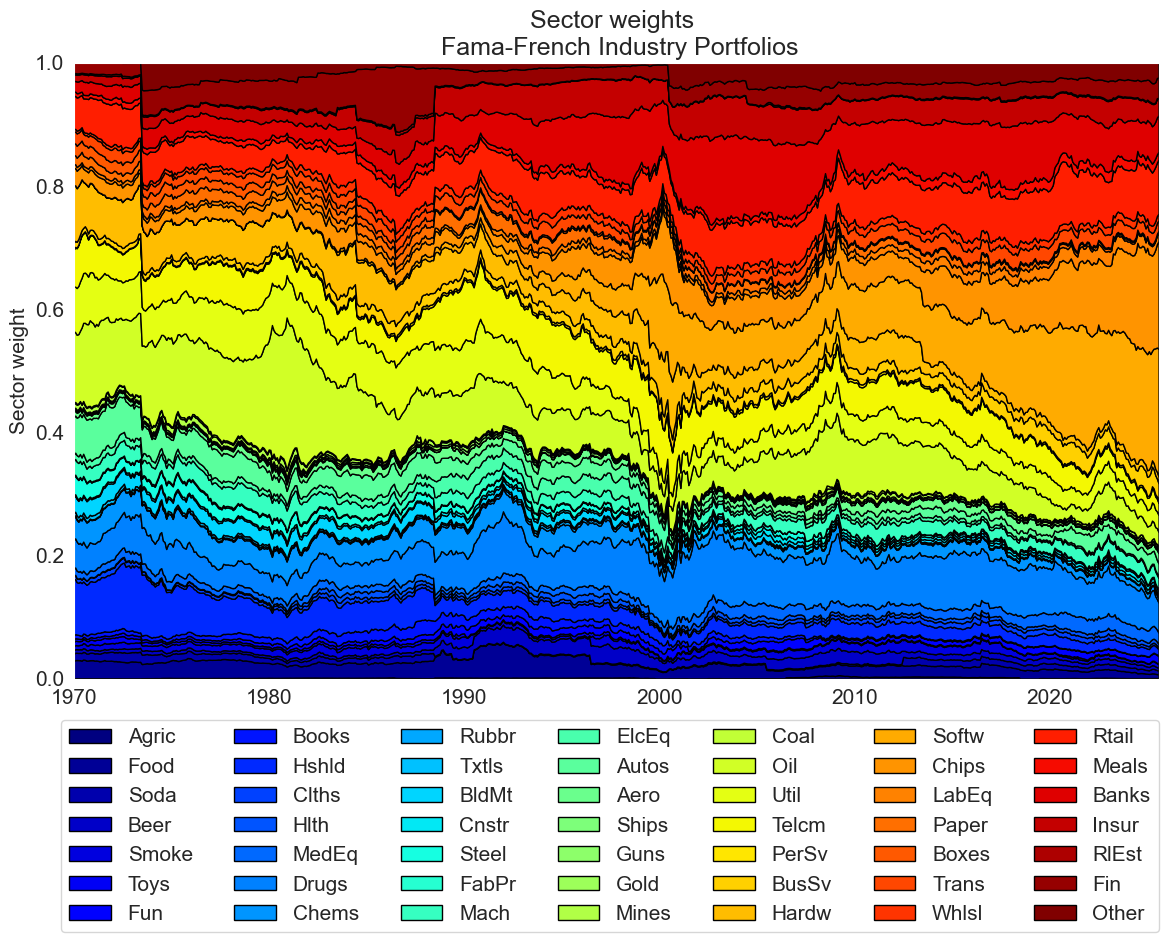

In [12]:
"""
Portfolio weights over time
"""

fig, ax = plt.subplots(figsize=(14, 8))

ax.stackplot(df_weights.index.to_timestamp(),
              df_weights.values.T,
              edgecolor="black",
              labels=df_weights.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weight')
ax.set_title("Sector weights \n Fama-French Industry Portfolios");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

A simplistic or naive view of portfolio diversification is to look at the number of constituents in the portfolios or the portfolio weights. One possibility is to use the norm of the portfolio weight vector, $\mathbf{w}$, to determine the Effective Number of Constituents (ENC)  (valid for any $\alpha > 0$ if weights are all positive)

\begin{equation*}
\text{ENC}_{\alpha} (\mathbf{w}) = \Vert \mathbf{w} \Vert_{\alpha}^{\frac{\alpha}{1 - \alpha}} = \left(\sum_{i=1}^N w_i^\alpha \right)^{\frac{1}{1-\alpha}}, \; \; \alpha > 0, \; \alpha \neq 1
\end{equation*}

where $N$ denote the number of assets. If $\alpha = 2$, the diversification measure is equal to the inverse of the [Herfindahl index](https://en.wikipedia.org/wiki/Herfindahl%E2%80%93Hirschman_index)

\begin{equation*}
\text{ENC}_{2} (\mathbf{w}) = \frac{1}{\sum_{i=1}^N w_i^2}
\end{equation*}

In the limiting case when $\alpha \to 1$, we obtain the exponential of the entropy of the distribution of the portfolio weight vector

\begin{equation*}
\text{ENC}_{1} = \exp \left( - \sum_{i=1}^N w_i \ln w_i\right)
\end{equation*}

__Note:__ The function to calculate ENC is defined in `codelib.portfolio_optimization.diversification`.

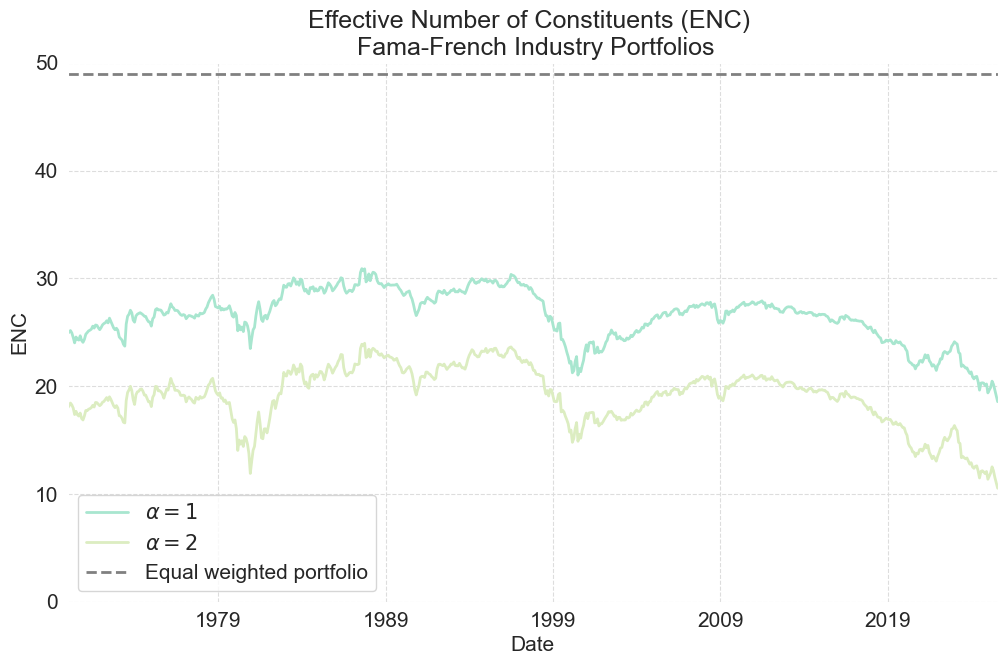

In [13]:
"""
Calculate Effective Number of Constituents (ENC) based on market capitialization
"""

df_enc1 = df_weights.apply(dm.calculate_enc, axis=1)
df_enc2 = df_weights.apply(dm.calculate_enc, axis=1, args=(2,))

fig, ax = plt.subplots(figsize=(12, 7))

df_enc1.plot(ax=ax, label="$\\alpha=1$")
df_enc2.plot(ax=ax, label="$\\alpha=2$")

ax.axhline(49, color='gray', linestyle='--', label="Equal weighted portfolio")
ax.set_ylim([0.0, 50.0])

ax.set_ylabel("ENC")
ax.set_title("Effective Number of Constituents (ENC) \n Fama-French Industry Portfolios")

ax.legend();

### Finding "optimal" portfolios

We choose an estimation horizon of one week since it provides a good trade off between the number of independent observations and the homogeneity of the data. 

Furthermore, we choose to use Exponential Weighted Moving Average (EWMA) filter to estimate the covariance matrix. We apply a window of 5 years of weekly observations and a half-life of 104 weeks (2 years).  

I use the "Average Value weighted Returns", but you can also choose to use the "Average Equal Weighted Returns". 

To perform the analysis, we can use `calculate_exponential_decay_probabilities` to calculate exponential probabilities. Given the probabilities, we can use `calculate_cov_mat` to calculate the covariance matrix. To calculate the risk contributions, we can use `calculate_risk_contributions_std`. All functions are imported in the begining of the notebook. 

In [14]:
"""
Calculate daily total return index
"""

ff_daily_ret = ff_daily_dict[0] / 100 # daily ret trans
ff_daily_prices = (1+ff_daily_ret).cumprod()

"""
Calculate weekly prices and return index
"""

ff_weekly_prices = ff_daily_prices.resample('W-WED').last()  # W-WED
ff_weekly_ret = ff_weekly_prices / ff_weekly_prices.shift(1) - 1
ff_weekly_ret.iloc[0, :] = ff_weekly_prices.iloc[0, :] - 1

In [15]:
"""
Initialize values
"""

# number of periods
num_periods = len(ff_weekly_ret)

# number of factors
num_assets = ff_weekly_ret.shape[1]

# window size 
window_size =  52 * 5 # 5 years of weekly observations 

# effective number of periods
eff_num_periods = num_periods - window_size

# half-life
half_life = 104

# time points
time_points = np.arange(1, window_size + 1)

# exponential probabilities 
exp_probs = calculate_exponential_decay_probabilities(window_size, time_points, half_life)

# equally weighted portfolio
eq_weigts = np.repeat(1.0 / num_assets, num_assets)

In [16]:
"""
Calculate optimal portfolios
"""

most_div_port_weights = np.zeros((eff_num_periods, num_assets))
min_var_port_weights = np.zeros((eff_num_periods, num_assets))
min_var_norm_port_weights = np.zeros((eff_num_periods, num_assets))
rp_port_weights = np.zeros((eff_num_periods, num_assets))

cc_ratios = np.zeros(eff_num_periods)
most_div_port_cc = np.zeros(eff_num_periods)
min_var_port_cc = np.zeros(eff_num_periods)
min_var_norm_port_cc = np.zeros(eff_num_periods)
rp_port_cc = np.zeros(eff_num_periods)

"""
Perform calculations
"""

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = moments.calculate_cov_mat(ff_weekly_ret.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # equally weighted
    cc_ratios[t] = calculate_cc_ratio(eq_weigts, cov_mat)
    
    # most diversified
    most_div_port_weights[t, :] = calculate_most_diversified_portfolio(cov_mat)
    most_div_port_cc[t] = calculate_cc_ratio(most_div_port_weights[t, :], cov_mat)
    
    # minimum variance
    min_var_port_weights[t, :] = calculate_minimum_variance(cov_mat)
    min_var_port_cc[t] = calculate_cc_ratio(min_var_port_weights[t, :], cov_mat)
    
    # minimum variance norm-constrained
    min_var_norm_port_weights[t, :] = calculate_minimum_variance_norm(cov_mat, delta=0.05)
    min_var_norm_port_cc[t] = calculate_cc_ratio(min_var_norm_port_weights[t, :], cov_mat)
    
    # risk parity
    rp_port_weights[t, :] = calculate_risk_parity(cov_mat)
    rp_port_cc[t] = calculate_cc_ratio(rp_port_weights[t, :], cov_mat)

C:\Users\johan\anaconda3\envs\fin_econ_2025\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


### Plotting allocations

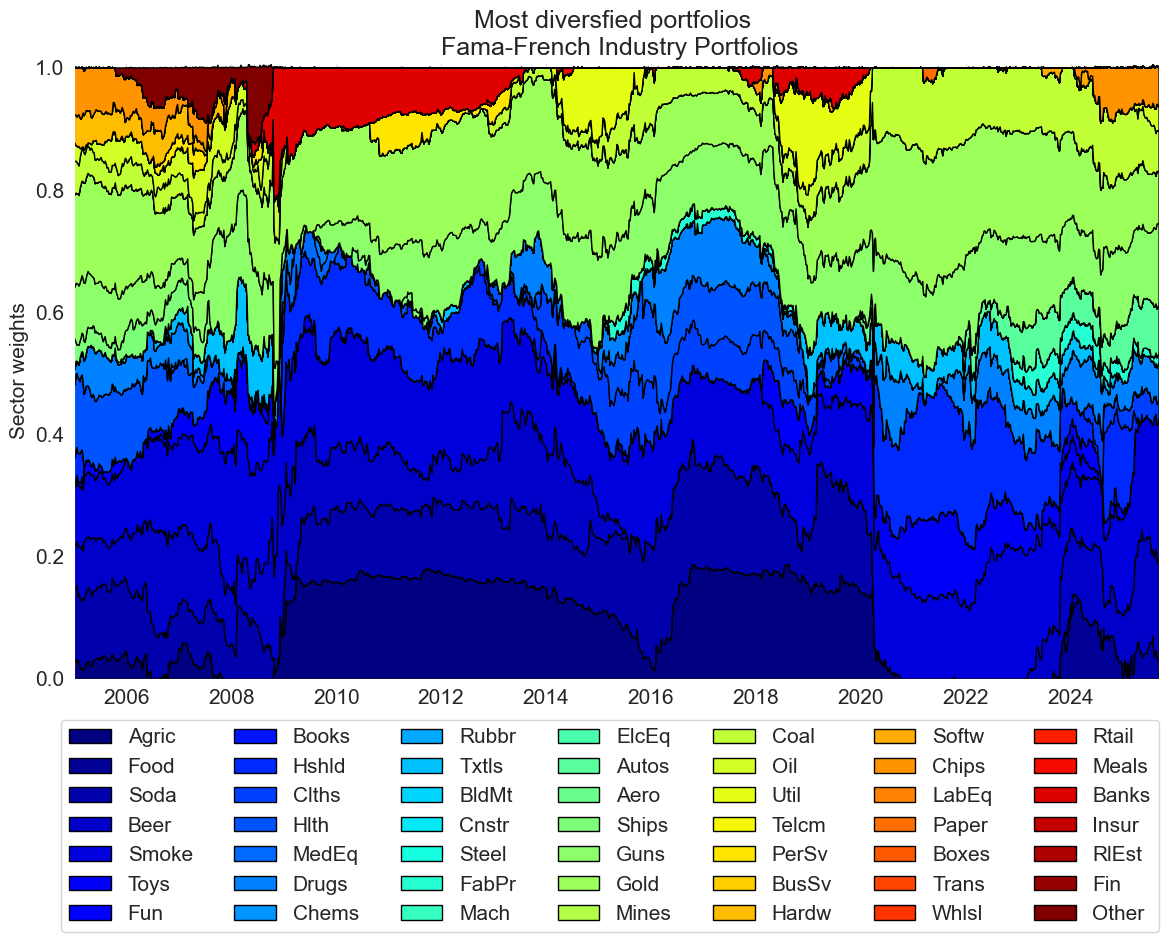

In [17]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.stackplot(ff_weekly_ret.index[window_size:],
              most_div_port_weights.T,
              edgecolor="black",
              labels=df_weights.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weights')
ax.set_title("Most diversfied portfolios \n Fama-French Industry Portfolios");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

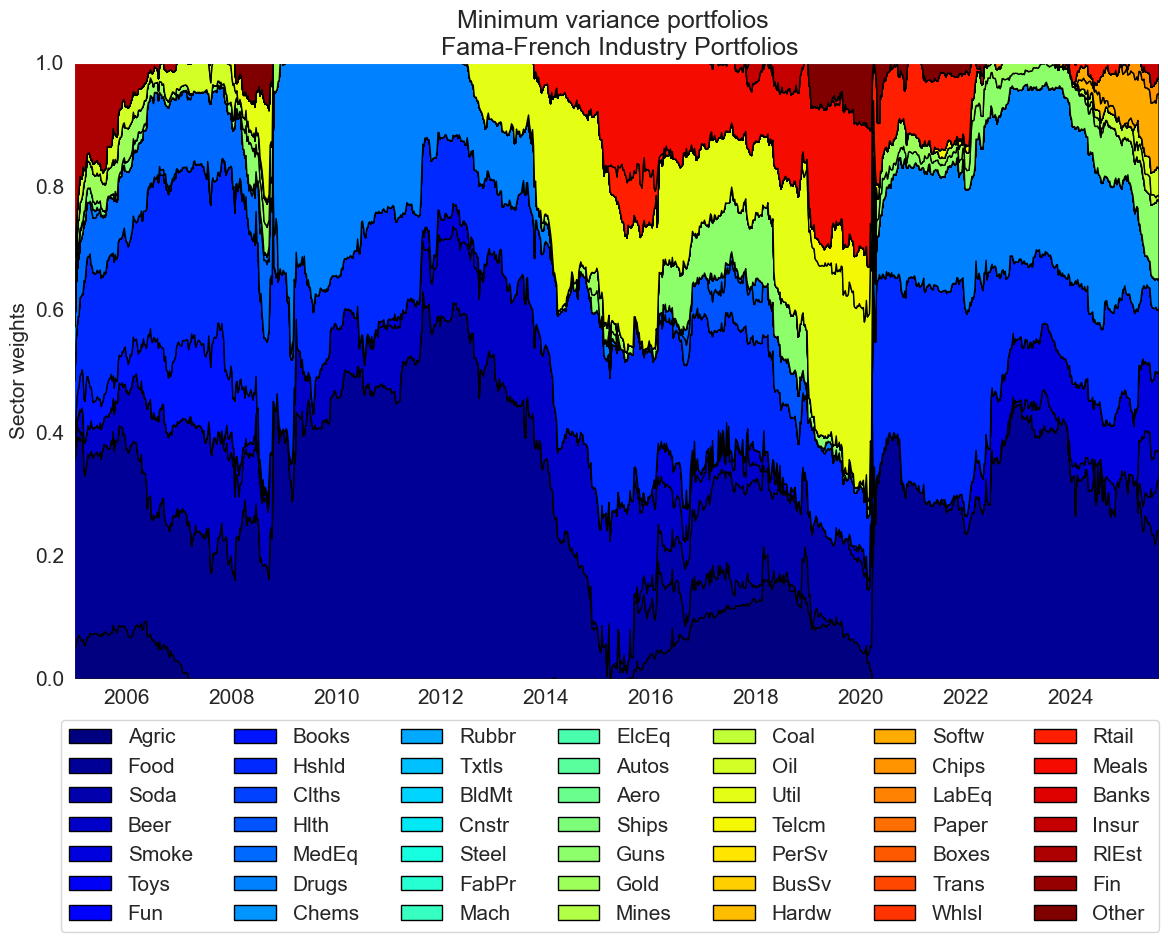

In [18]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.stackplot(ff_weekly_ret.index[window_size:],
              min_var_port_weights.T,
              edgecolor="black",
              labels=df_weights.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weights')
ax.set_title("Minimum variance portfolios \n Fama-French Industry Portfolios");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

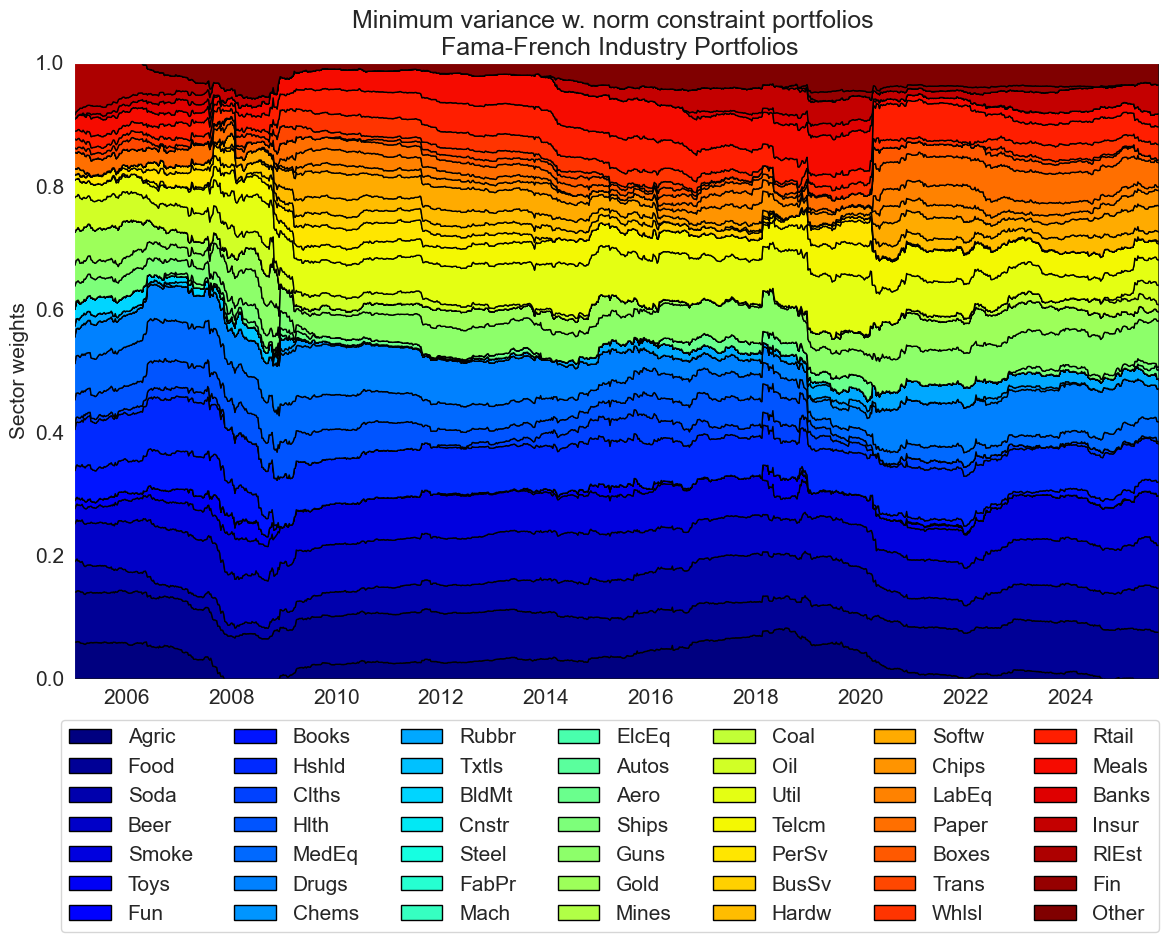

In [19]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.stackplot(ff_weekly_ret.index[window_size:],
              min_var_norm_port_weights.T,
              edgecolor="black",
              labels=df_weights.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weights')
ax.set_title("Minimum variance w. norm constraint portfolios \n Fama-French Industry Portfolios");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

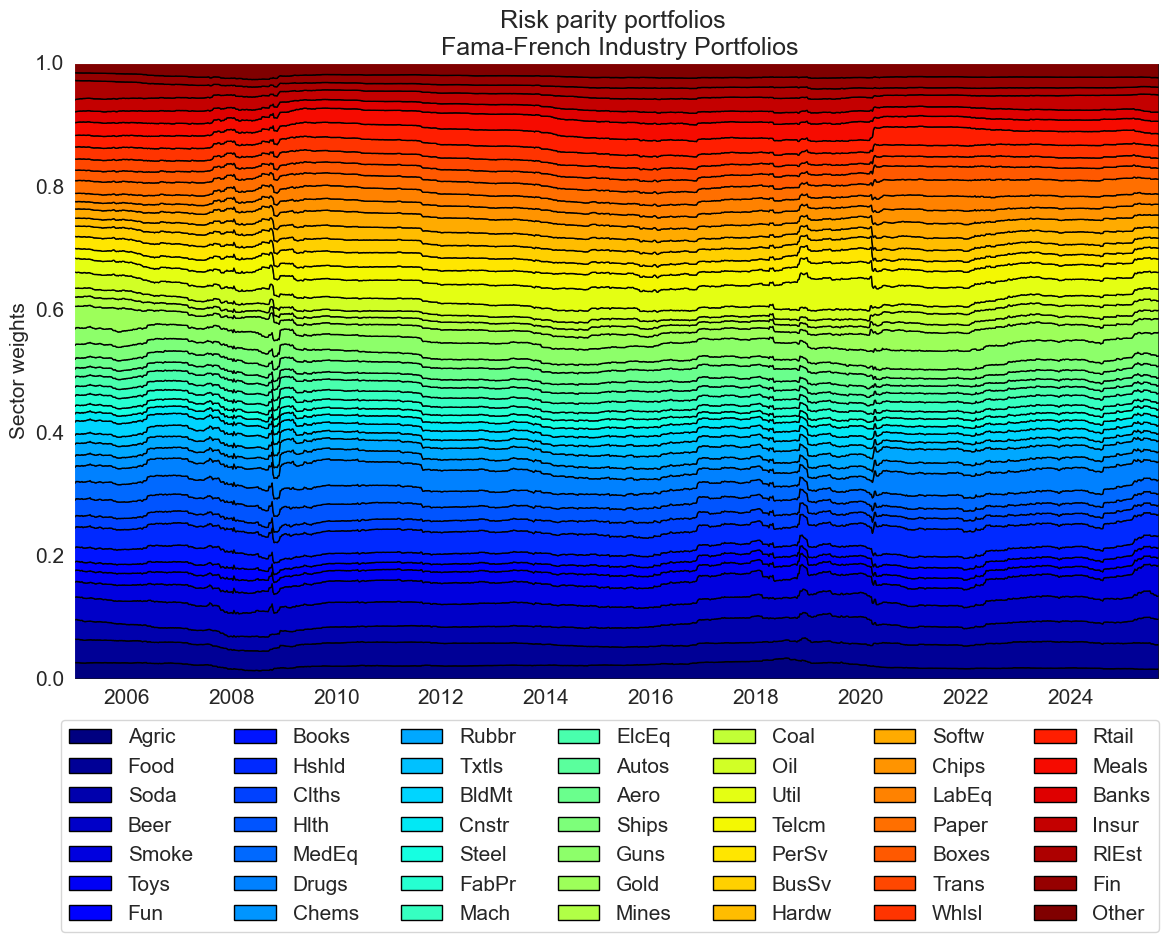

In [20]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.stackplot(ff_weekly_ret.index[window_size:],
              rp_port_weights.T,
              edgecolor="black",
              labels=df_weights.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weights')
ax.set_title("Risk parity portfolios \n Fama-French Industry Portfolios");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

### Diversification ratios

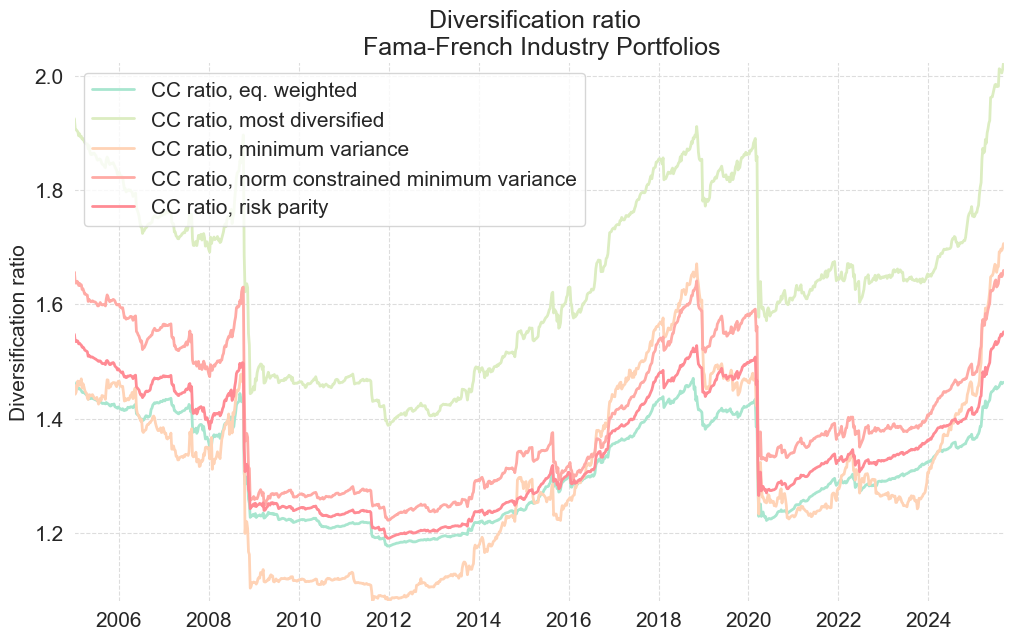

In [21]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(ff_weekly_ret.index[window_size:], cc_ratios, label="CC ratio, eq. weighted")
ax.plot(ff_weekly_ret.index[window_size:], most_div_port_cc, label="CC ratio, most diversified")
ax.plot(ff_weekly_ret.index[window_size:], min_var_port_cc, label="CC ratio, minimum variance")
ax.plot(ff_weekly_ret.index[window_size:], min_var_norm_port_cc, label="CC ratio, norm constrained minimum variance")
ax.plot(ff_weekly_ret.index[window_size:], rp_port_cc, label="CC ratio, risk parity")
ax.set_ylabel("Diversification ratio")
ax.set_title("Diversification ratio \n Fama-French Industry Portfolios");
ax.legend();

### Evaluating strategies

In [22]:
# store in data-frames
df_most_div_port_weights = pd.DataFrame(data=most_div_port_weights,
                                        index=ff_weekly_ret[window_size:].index,
                                        columns=ff_weekly_ret.columns)

df_min_var_port_weights = pd.DataFrame(data=min_var_port_weights,
                                       index=ff_weekly_ret[window_size:].index,
                                       columns=ff_weekly_ret.columns)

df_min_var_norm_port_weights = pd.DataFrame(data=min_var_norm_port_weights,
                                            index=ff_weekly_ret[window_size:].index,
                                            columns=ff_weekly_ret.columns)

df_rp_port_weights = pd.DataFrame(data=rp_port_weights,
                                  index=ff_weekly_ret[window_size:].index,
                                  columns=ff_weekly_ret.columns)

In [23]:
df_port_ret = pd.DataFrame(index=ff_weekly_ret.index[window_size:])

# weekly return
df_port_ret['min-var'] = (ff_weekly_ret[window_size:] * df_min_var_port_weights).sum(axis=1)
df_port_ret['most-div'] = (ff_weekly_ret[window_size:] * df_most_div_port_weights).sum(axis=1)
df_port_ret['min-var-norm'] = (ff_weekly_ret[window_size:] * df_min_var_norm_port_weights).sum(axis=1)
df_port_ret['rp'] = (ff_weekly_ret[window_size:] * df_rp_port_weights).sum(axis=1)
df_port_ret['eq-weight'] = (ff_weekly_ret[window_size:] @ eq_weigts)

# total return index
df_port_tri = (1 + df_port_ret).cumprod(axis=0)

In [24]:
(1 + df_port_ret).prod(axis=0)

min-var         5.370006
most-div        6.455476
min-var-norm    6.921825
rp              7.628544
eq-weight       7.944470
dtype: float64

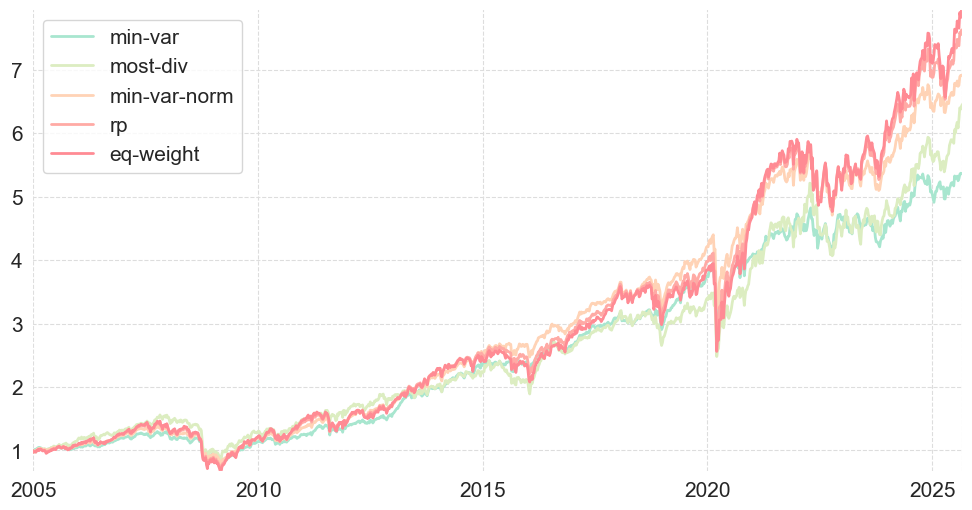

In [25]:
df_port_tri.plot(xlabel="", figsize=(12, 6));

In [26]:
mean_return = df_port_ret.mean(axis=0)
mean_return

min-var         0.001701
most-div        0.001991
min-var-norm    0.001971
rp              0.002161
eq-weight       0.002260
dtype: float64

In [27]:
std_return = df_port_ret.std(axis=0)
std_return

min-var         0.016865
most-div        0.022830
min-var-norm    0.018746
rp              0.023375
eq-weight       0.025852
dtype: float64

The information ratio is given by 

\begin{equation*}
\text{IR} = \frac{\text{E}[R_p]}{\sigma_P}
\end{equation*}

where $R_p$ is the portfolio return and $\sigma_P$ is the portfolio standard deviation (need to be replaced with estimates). 

In [28]:
ir_ratio = mean_return / std_return
ir_ratio

min-var         0.100881
most-div        0.087198
min-var-norm    0.105139
rp              0.092435
eq-weight       0.087434
dtype: float64

We can define turn-over as 

\begin{equation*}
\text{Turn-Over} = \frac{1}{T_{OOS} - 1}\sum_{t=1}^{T_{OOS} - 1} \sum_{i=1}^N \vert \tilde{w}_{i, t+1} - w_{i, t+1} \vert
\end{equation*}

where $T_{OOS} - 1$ is the number of re-balancing dates and 

\begin{equation*}
\tilde{w}_{i, t+1} = \frac{w_{i, t}(1 + R_{i, t+1})}{1+R_{p, t+1}}
\end{equation*}

is the portfolio weight of asset $i$ immediately before re-balancing.

In [29]:
def calculate_turn_over(df_port_weights, df_asset_return): 
    
    df_port_ret = (df_asset_return * df_port_weights).sum(axis=1)
    df_adj_weights = ((1 + df_asset_return) * df_port_weights).divide(1 + df_port_ret.values, axis=0)
    df_w_diff = (df_adj_weights.shift(1) - df_port_weights).dropna()
    
    return np.mean(np.linalg.norm(df_w_diff, axis=1, ord=1)) * 100

In [30]:
calculate_turn_over(df_min_var_port_weights, ff_weekly_ret[window_size:])

np.float64(5.215647498617755)

In [31]:
df_turn_over = pd.DataFrame(data=[], index=["Turn-over"])
df_turn_over.loc[:, 'eq-weight'] = calculate_turn_over(eq_weigts, ff_weekly_ret[window_size:])
df_turn_over.loc[:, 'min-var'] = calculate_turn_over(df_min_var_port_weights, ff_weekly_ret[window_size:])
df_turn_over.loc[:,'most-div'] = calculate_turn_over(df_most_div_port_weights, ff_weekly_ret[window_size:])
df_turn_over.loc[:, 'min-var-norm'] = calculate_turn_over(df_min_var_norm_port_weights, ff_weekly_ret[window_size:])
df_turn_over.loc[:, 'rp'] = calculate_turn_over(df_rp_port_weights, ff_weekly_ret[window_size:])

df_turn_over

,eq-weight,min-var,most-div,min-var-norm,rp
Turn-over,1.577172,5.215647,5.559991,2.284455,1.571661


## Transaction costs

We would like to implement $0.002$ proportional transaction costs (just in the evaluation)

In [32]:
tc = 20 / 100 / 100

def calculate_return_w_tc(df_port_weights, df_asset_return, transaction_cost: float = 0.005):

    df_port_ret = (df_asset_return * df_port_weights).sum(axis=1)
    df_adj_weights = ((1 + df_asset_return) * df_port_weights).divide(1 + df_port_ret.values, axis=0)

    # calculate changes in weights, when taking returns into account
    df_w_diff = (df_adj_weights.shift(1) - df_port_weights)
    df_w_diff.iloc[0, :] = 0.0 # assume that the initial portfolio is hold initially, so no transaction for the first optimization. Alternative a large transaction.

    return df_port_ret - transaction_cost * np.abs(df_w_diff).sum(axis=1)

In [33]:
df_port_ret_w_tc = pd.DataFrame(index=ff_weekly_ret.index[window_size:])

df_port_ret_w_tc['min-var'] = calculate_return_w_tc(df_min_var_port_weights, ff_weekly_ret[window_size:], tc)
df_port_ret_w_tc['most-div'] = calculate_return_w_tc(df_most_div_port_weights, ff_weekly_ret[window_size:], tc)
df_port_ret_w_tc['min-var-norm'] = calculate_return_w_tc(df_min_var_norm_port_weights, ff_weekly_ret[window_size:], tc)
df_port_ret_w_tc['rp'] = calculate_return_w_tc(df_rp_port_weights, ff_weekly_ret[window_size:], tc)
df_port_ret_w_tc['eq-weight'] = calculate_return_w_tc(eq_weigts, ff_weekly_ret[window_size:], tc)

# total return index
df_port_tri_w_tc = (1 + df_port_ret_w_tc).cumprod(axis=0)

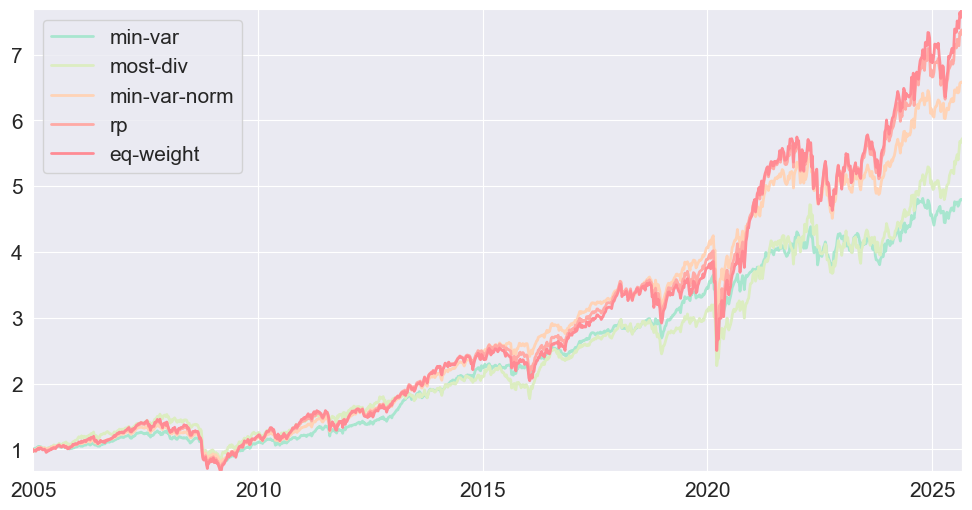

In [34]:
df_port_tri_w_tc.plot(xlabel="", figsize=(12, 6));

In [35]:
(1 + df_port_ret_w_tc).prod(axis=0)

min-var         4.797770
most-div        5.725811
min-var-norm    6.588696
rp              7.374276
eq-weight       7.679008
dtype: float64

In [36]:
df_port_ret_w_tc.mean(axis=0) / df_port_ret_w_tc.std(axis=0)

min-var         0.094626
most-div        0.082317
min-var-norm    0.102679
rp              0.091087
eq-weight       0.086215
dtype: float64

## Literature 

[Bruder and Roncalli (2012), "Managing Risk Exposures using
the Risk Budgeting Approach"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2009778)

[Choueifaty and Caignard (2008), "Toward Maximum Diversification"](https://www.tobam.fr/wp-content/uploads/2014/12/TOBAM-JoPM-Maximum-Div-2008.pdf)

[Victor DeMiguel, Lorenzo Garlappi, Francisco J. Nogales and Raman Uppal (2009), "A Generalized Approach to Portfolio Optimization: Improving Performance by Constraining Portfolio Norms"](https://www.jstor.org/stable/40539189)